In [1]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt


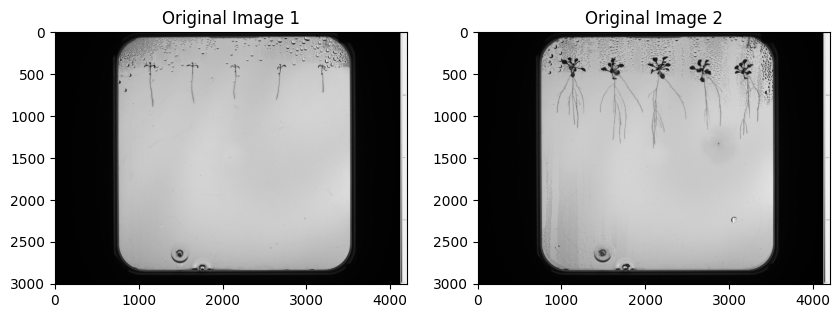

In [2]:
# Load grayscale images
image1 = cv2.imread('task_3_image_1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('task_3_image_2.png', cv2.IMREAD_GRAYSCALE)

# Display the original images (optional, for inspection)
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.title("Original Image 1"), plt.imshow(image1, cmap='gray')
plt.subplot(122), plt.title("Original Image 2"), plt.imshow(image2, cmap='gray')
plt.show()


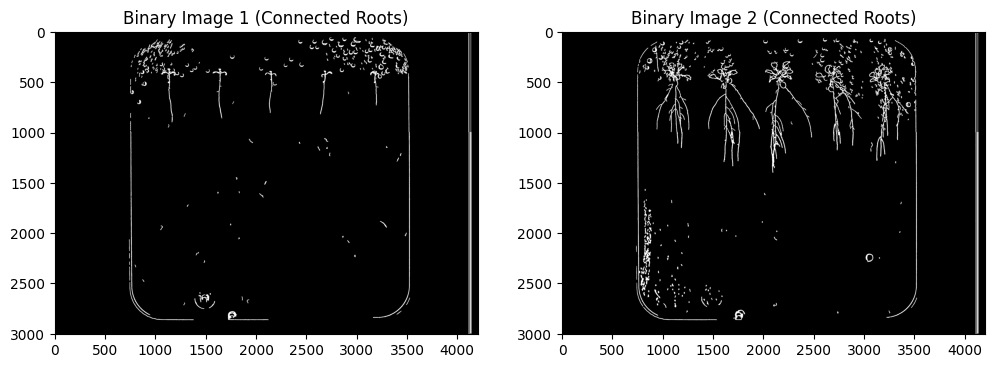

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing with enhanced root detail preservation for Image 2
def preprocess_image_for_faint_roots(image):
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Adaptive thresholding with fine-tuned parameters
    binary = cv2.adaptiveThreshold(
        enhanced_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,  # Smaller block size
        7    # Lower constant to retain faint roots
    )
    return binary

# Function to preserve plants and roots while removing bubbles
def remove_bubbles_and_keep_plants(binary_image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    mask = np.zeros(binary_image.shape, dtype=np.uint8)
    
    for i in range(1, num_labels):  # Skip background
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        aspect_ratio = height / width if width > 0 else 0

        # Preserve plant structures based on aspect ratio and size
        if area > 50 and (aspect_ratio > 1.2 or height > 30):
            mask[labels == i] = 255
    
    # Apply morphology to refine plant structures
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    refined_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return refined_mask

# Function to enhance and connect faint roots in Image 2
def connect_faint_roots(binary_image):
    height, width = binary_image.shape
    lower_region = binary_image[height // 3:, :]  # Focus on bottom one-third (roots)

    # Closing with a narrow kernel
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    connected_roots = cv2.morphologyEx(lower_region, cv2.MORPH_CLOSE, kernel_close, iterations=4)

    # Dilate and erode iteratively to fill gaps
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    connected_roots = cv2.dilate(connected_roots, kernel_dilate, iterations=3)
    connected_roots = cv2.erode(connected_roots, kernel_dilate, iterations=2)

    # Combine upper and lower regions
    upper_region = binary_image[:height // 3, :]
    combined_image = np.vstack((upper_region, connected_roots))
    return combined_image

# Function to remove bubbles in the top region
def remove_top_bubbles(binary_image):
    height, width = binary_image.shape
    top_region = binary_image[:height // 4, :]  # Top 25% region
    bottom_region = binary_image[height // 4:, :]  # Bottom 75% region

    # Remove small circular bubbles in the top region
    contours, _ = cv2.findContours(top_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue
        
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        if area < 1500 and circularity > 0.4:  # Bubble-like objects
            cv2.drawContours(top_region, [contour], -1, (0), thickness=cv2.FILLED)

    # Combine top and bottom regions
    refined_image = np.vstack((top_region, bottom_region))
    return refined_image

# Final cleanup to enhance plant-root structures
def final_cleanup(binary_image):
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    # Closing to fill gaps
    cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel_close)
    # Dilation to ensure connectivity
    cleaned_image = cv2.dilate(cleaned_image, kernel_dilate, iterations=2)
    return cleaned_image

# Workflow
def process_images(image1, image2):
    # Preprocess images to preserve roots
    binary1_preserving_roots = preprocess_image_for_faint_roots(image1)
    binary2_preserving_roots = preprocess_image_for_faint_roots(image2)

    # Preserve plants and roots while removing bubbles
    binary1_plants_only = remove_bubbles_and_keep_plants(binary1_preserving_roots)
    binary2_plants_only = remove_bubbles_and_keep_plants(binary2_preserving_roots)

    # Remove bubbles in the top region
    binary1_no_top_bubbles = remove_top_bubbles(binary1_plants_only)
    binary2_no_top_bubbles = remove_top_bubbles(binary2_plants_only)

    # Enhance and connect faint roots
    binary1_connected_roots = connect_faint_roots(binary1_no_top_bubbles)
    binary2_connected_roots = connect_faint_roots(binary2_no_top_bubbles)

    # Final cleanup to remove noise
    binary1_final_output = final_cleanup(binary1_connected_roots)
    binary2_final_output = final_cleanup(binary2_connected_roots)

    # Display the final results
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.title("Binary Image 1 (Connected Roots)"), plt.imshow(binary1_final_output, cmap='gray')
    plt.subplot(122), plt.title("Binary Image 2 (Connected Roots)"), plt.imshow(binary2_final_output, cmap='gray')
    plt.show()

    return binary1_final_output, binary2_final_output

# Load the grayscale images
image1 = cv2.imread('task_3_image_1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('task_3_image_2.png', cv2.IMREAD_GRAYSCALE)

# Process the images
binary1_result, binary2_result = process_images(image1, image2)


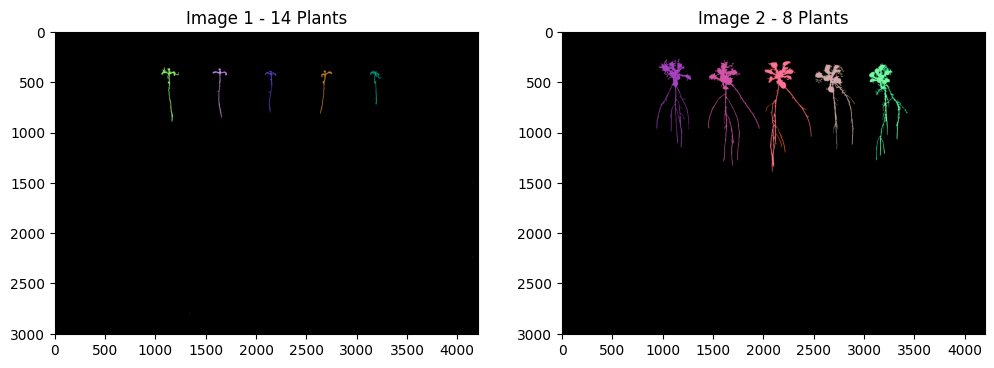

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess and generate binary images
def preprocess_image(image, threshold_value=127):
    """
    Preprocesses the image with adjustable binary thresholding.
    Args:
        image: Grayscale image.
        threshold_value: Threshold value for binarization (0-255).
    Returns:
        binary: Binary image.
    """
    _, binary = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    return binary

# Function to merge adjacent components and improve segmentation
def merge_adjacent_components(binary_image, merge_threshold=10):
    """
    Merge adjacent components to ensure the middle plant root is detected as a single entity.
    Args:
        binary_image: Binary image after segmentation.
        merge_threshold: Distance threshold to merge nearby components.
    Returns:
        merged_image: Binary image with merged components.
    """
    # Find contours of the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    merged_image = np.zeros_like(binary_image)

    # Merge components based on proximity
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Create a bounding box around each component and expand it slightly
        x_start = max(x - merge_threshold, 0)
        y_start = max(y - merge_threshold, 0)
        x_end = min(x + w + merge_threshold, binary_image.shape[1])
        y_end = min(y + h + merge_threshold, binary_image.shape[0])
        cv2.rectangle(merged_image, (x_start, y_start), (x_end, y_end), 255, thickness=cv2.FILLED)

    # Perform a bitwise AND with the original binary image to refine the merged output
    merged_image = cv2.bitwise_and(merged_image, binary_image)

    return merged_image

# Function to segment individual plants while ignoring bubbles and lines
def instance_segmentation_ignore_lines(binary_image, area_threshold=500, aspect_ratio_min=1.2, aspect_ratio_max=5):
    """
    Perform instance segmentation to identify individual plants and exclude unwanted outlines.
    Args:
        binary_image: Binary image after preprocessing.
        area_threshold: Minimum area to consider as a plant.
        aspect_ratio_min: Minimum aspect ratio of a valid plant.
        aspect_ratio_max: Maximum aspect ratio of a valid plant.
    Returns:
        labeled_image: Image with each plant labeled with a unique color.
        num_plants: Number of detected plants.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    height, width = binary_image.shape
    labeled_image = np.zeros((height, width, 3), dtype=np.uint8)
    plant_count = 0

    # Generate random colors for each label
    colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)

    for i in range(1, num_labels):  # Skip background
        area = stats[i, cv2.CC_STAT_AREA]
        width_component = stats[i, cv2.CC_STAT_WIDTH]
        height_component = stats[i, cv2.CC_STAT_HEIGHT]
        aspect_ratio = height_component / width_component if width_component > 0 else 0

        # Ignore bubbles, small objects, and outline lines based on area and aspect ratio
        if area > area_threshold and aspect_ratio_min < aspect_ratio < aspect_ratio_max:
            plant_count += 1
            labeled_image[labels == i] = colors[i]  # Assign a unique color

    return labeled_image, plant_count

# Function to tweak segmentation parameters with independent specs for image1 and image2
def tweak_segmentation(image1, image2, 
                       threshold_value1=127, area_threshold1=500, aspect_ratio_min1=1.2, aspect_ratio_max1=5,
                       threshold_value2=127, area_threshold2=3000, aspect_ratio_min2=0.5, aspect_ratio_max2=30.0,
                       threshold_value2_left=162.5, area_threshold2_left=3890, aspect_ratio_min2_left=2.0, aspect_ratio_max2_left=25.0):
    """
    Allows tweaking segmentation parameters for better results with independent specs for two images.
    Includes an additional pass for Image 2 to capture the leftmost plant.
    Args:
        image1: First grayscale image.
        image2: Second grayscale image.
        threshold_value1: Threshold value for binarization of image1 (0-255).
        area_threshold1: Minimum area to consider as a plant in image1.
        aspect_ratio_min1: Minimum aspect ratio of a valid plant in image1.
        aspect_ratio_max1: Maximum aspect ratio of a valid plant in image1.
        threshold_value2: Threshold value for binarization of image2 (0-255).
        area_threshold2: Minimum area to consider as a plant in image2.
        aspect_ratio_min2: Minimum aspect ratio of a valid plant in image2.
        aspect_ratio_max2: Maximum aspect ratio of a valid plant in image2.
        threshold_value2_left: Threshold value to specifically capture the leftmost plant in image2.
        area_threshold2_left: Minimum area to consider as a plant in the second pass for image2.
        aspect_ratio_min2_left: Minimum aspect ratio for the second pass for image2.
        aspect_ratio_max2_left: Maximum aspect ratio for the second pass for image2.
    Returns:
        labeled_image1: Segmented first image.
        labeled_image2_combined: Combined segmented second image.
    """
    # Preprocess the images with independent thresholds
    binary1 = preprocess_image(image1, threshold_value1)
    binary1 = merge_adjacent_components(binary1)  # Merge adjacent components for image 1

    binary2_general = preprocess_image(image2, threshold_value2)
    binary2_general = merge_adjacent_components(binary2_general)  # Merge adjacent components for general image 2

    binary2_left = preprocess_image(image2, threshold_value2_left)
    binary2_left = merge_adjacent_components(binary2_left)  # Merge adjacent components for leftmost image 2

    # Segment the plants for image 1
    labeled_image1, num_plants1 = instance_segmentation_ignore_lines(
        binary1, area_threshold1, aspect_ratio_min1, aspect_ratio_max1)

    # Segment the plants for image 2 (general case)
    labeled_image2_general, num_plants2_general = instance_segmentation_ignore_lines(
        binary2_general, area_threshold2, aspect_ratio_min2, aspect_ratio_max2)

    # Segment the leftmost plant in image 2
    labeled_image2_left, num_plants2_left = instance_segmentation_ignore_lines(
        binary2_left, area_threshold2_left, aspect_ratio_min2_left, aspect_ratio_max2_left)

    # Combine the results for image 2
    labeled_image2_combined = np.maximum(labeled_image2_general, labeled_image2_left)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.title(f"Image 1 - {num_plants1} Plants"), plt.imshow(labeled_image1)
    plt.subplot(122), plt.title(f"Image 2 - {num_plants2_general + num_plants2_left} Plants"), plt.imshow(labeled_image2_combined)
    plt.show()

    return labeled_image1, labeled_image2_combined

# Load the grayscale images
image1 = cv2.imread('task_3_image_1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('task_3_image_2.png', cv2.IMREAD_GRAYSCALE)

# Segmentation specifications for image 1
threshold_value1 = 160  # Adjust thresholding value (0-255)
area_threshold1 = 1.0   # Minimum size of a valid plant
aspect_ratio_min1 = 3.0 # Minimum aspect ratio
aspect_ratio_max1 = 10.0 # Maximum aspect ratio

# Segmentation specifications for image 2 (general case)
threshold_value2 = 176  # General case
area_threshold2 = 2100  # Minimum size of a valid plant
aspect_ratio_min2 = 2.0 # Broader range for smaller/broader plants
aspect_ratio_max2 = 25.0 # Increased maximum aspect ratio to capture tall plants

# Segmentation specifications for image 2 (leftmost plant)
threshold_value2_left = 162.5  # Optimized for the leftmost plant
area_threshold2_left = 3900  # Specific size for the leftmost plant
aspect_ratio_min2_left = 2.0  # Aspect ratio for the leftmost plant
aspect_ratio_max2_left = 25.0 # Aspect ratio for the leftmost plant

# Process and Segment the Plants
labeled_image1, labeled_image2_combined = tweak_segmentation(
    image1, image2,
    threshold_value1=threshold_value1, area_threshold1=area_threshold1, 
    aspect_ratio_min1=aspect_ratio_min1, aspect_ratio_max1=aspect_ratio_max1,
    threshold_value2=threshold_value2, area_threshold2=area_threshold2, 
    aspect_ratio_min2=aspect_ratio_min2, aspect_ratio_max2=aspect_ratio_max2,
    threshold_value2_left=threshold_value2_left, area_threshold2_left=area_threshold2_left, 
    aspect_ratio_min2_left=aspect_ratio_min2_left, aspect_ratio_max2_left=aspect_ratio_max2_left
)
